In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob
from modules import TransUNET, EarlyStopping
from focal_loss import focal_loss

seed = 42

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


**Two underlying concepts**

**ViT**
<div><table><tr><td>
<img src="vit1.png" width="400"/>
<td><img src="vit2.ppm" width="400"/>
    </tr></table>
</div>

**Transformer UNET**
<img src="tunet.png" width="600" height="800"/>

In [4]:
BATCH_SIZE = 4
IMAGE_SIZE = 128
epochs = 200
num_classes = 3
PATH = os.path.join(os.getcwd() + '/breast')

label_to_int = {'normal': 0, 'benign': 1, 'malignant': 2}
int_to_label = {0: 'normal', 1: 'benign', 2: 'malignant'}

In [5]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.05),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [6]:
original_paths = glob(os.getcwd() + "/breast/*/*).png")
mask_paths = glob(os.getcwd() + "/breast/*/*mask.png")

original_paths = sorted([str(path) for path in original_paths])
mask_paths = sorted([str(path) for path in mask_paths])
labels = [label_to_int.get(path.split("\\")[-1].split()[0]) for path in mask_paths]

df = pd.DataFrame(data={"image": original_paths, "mask": mask_paths, "label": labels})

In [7]:
x_train, x_valid = train_test_split(df, train_size=700, shuffle=True, stratify=df["label"], random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=55, shuffle=True, stratify=x_valid["label"], random_state=seed)

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 700, validation size: 55, test size: 25.


In [8]:
class BreastDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = cv2.imread(row["image"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = Image.open(row["image"])
        # image = np.array(image)
        
        mask = cv2.imread(row["mask"])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = torch.as_tensor(mask/255, dtype=torch.float32)
        
        label = torch.as_tensor(row["label"], dtype=torch.int64)

        sample = self.transforms(**{"image": image})
        image = sample["image"]
        _mask = torch.zeros_like(mask, dtype=torch.int64)  # image
        _mask[mask == 1] = label
        
        return image, _mask
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [9]:
train_ds = BreastDataset(x_train, train_transforms)
valid_ds = BreastDataset(x_valid, valid_transforms)
test_ds = BreastDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [10]:
model = TransUNET(image_size=128, in_channels=3, out_channels=128, num_heads=4, mlp_dim=512, 
                  block_num=8, patch_dim=16, num_classes=num_classes, num_labels=num_classes).to(device)

# loss_masks = nn.CrossEntropyLoss()
loss_masks = focal_loss(gamma=2, device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, min_lr=1e-7, patience=10)
early = EarlyStopping(patience=20, path="model_mult.pth")

In [11]:
def train_one_batch(data, model, optimizer, msk_loss):
    model.train()
    images, masks = data
    
    optimizer.zero_grad()
    out, _ = model(images)
    loss = msk_loss(out, masks)

    loss.backward()
    optimizer.step()

    # msk_accuracy = (torch.max(out, 1)[1] == torch.max(masks, 1)[1]).float().mean()
    msk_accuracy = (torch.max(out, 1)[1] == masks).float().mean()
    
    return loss.item(), msk_accuracy.item()

@torch.no_grad()
def validate_one_batch(data, model, msk_loss):
    model.eval()
    images, masks = data
    out, _ = model(images)
    loss = msk_loss(out, masks)
    
    # msk_accuracy = (torch.max(out, 1)[1] == torch.max(masks, 1)[1]).float().mean()
    msk_accuracy = (torch.max(out, 1)[1] == masks).float().mean()
    
    return loss.item(), msk_accuracy.item()

@torch.no_grad()
def check_holdout(dl, model, sample=False):
    model.eval()
    
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(num_classes)])[:, None] * palette
    colors = (colors % 255).numpy() / 255
    
    plt.figure(figsize=(20, 20))
    i = 1
    for data in dl:
        ix = np.random.randint(0, 2) if sample else 1
        if ix:
            image, mask = data
            out, _ = model(image)
            out = out[0].argmax(0).cpu().detach().numpy()
            mask = mask[0].cpu().detach().numpy()

            image = inverse_transforms(image[0])
            
            labels, counts = np.unique(mask, return_counts=True)
            label = labels[0] if len(labels) == 1 else labels[1]
            
            labels, counts = np.unique(out, return_counts=True)
            if len(labels) == 1:
                pred = labels[0]  
            elif len(labels) > 2:
                pred = np.argmax(counts[1:]) + 1
            else:
                pred = labels[-1]
            
            for j in range(1, num_classes):
                image[mask == j, :] = (0.55,0,0)
                image[out == j, :] = colors[j].tolist()
            
            plt.subplot(7, 4, i)
            plt.title(f"Image with orig. mask ({int_to_label.get(label)}) and predicted ({int_to_label.get(pred)})")
            plt.imshow(image)
            i += 1
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)
    
def load_model(path, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model = checkpoint['model']
    return model

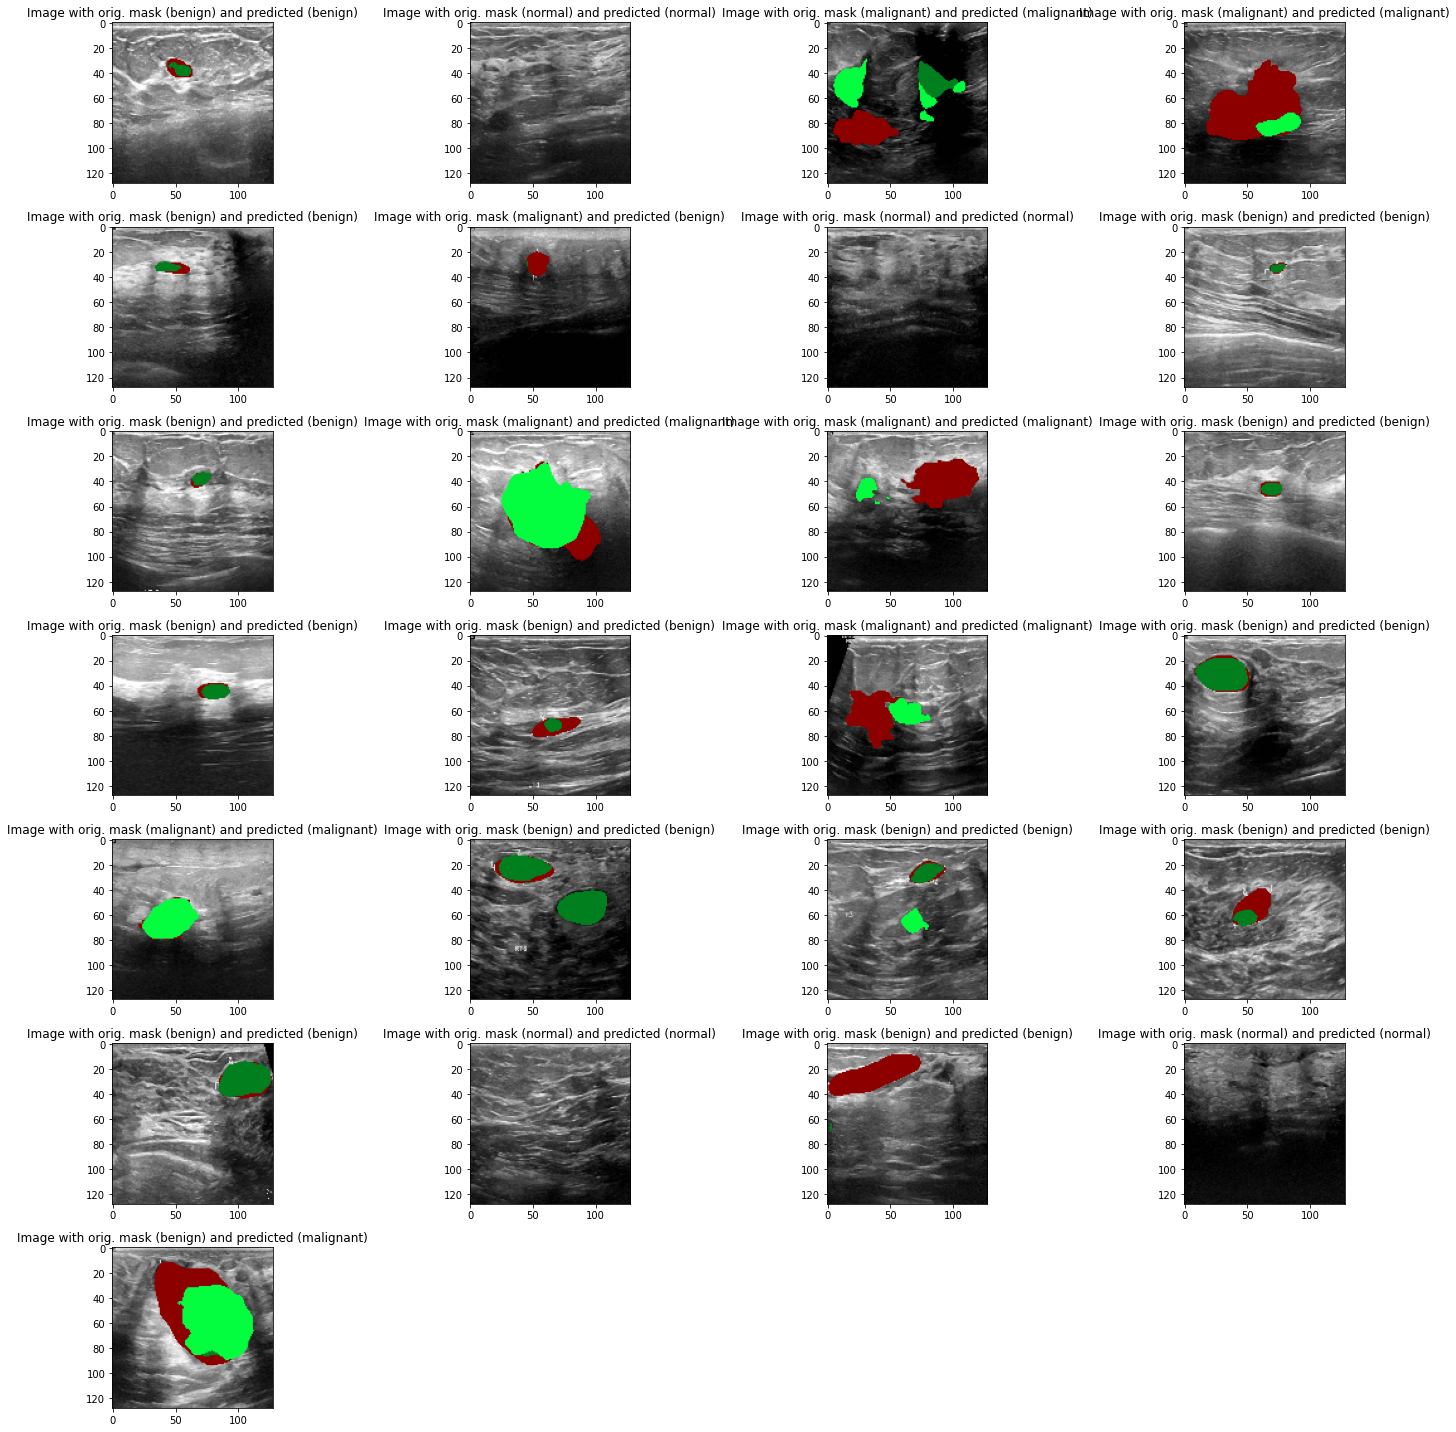

INFO: Early stopping counter 20 of 20
INFO: Early stopping
Validation loss did not improve for 20 epochs. Training stopped.


In [12]:
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    tq_bar = tqdm(train_dl, total=len(train_dl), desc=f'Train step {epoch+1}')
    epoch_train_losses = []
    for _, batch in enumerate(tq_bar):
        loss, msk_acc = train_one_batch(batch, model, optimizer, loss_masks)
        epoch_train_losses.append(loss)
        tq_bar.set_postfix(loss=np.mean(epoch_train_losses), cur_msk_acc=msk_acc)
    train_losses.append(np.mean(epoch_train_losses))
    
    tq_bar = tqdm(valid_dl, total=len(valid_dl), desc=f'Validation step {epoch+1}')
    epoch_valid_losses = []
    for _, batch in enumerate(tq_bar):
        loss, msk_acc = validate_one_batch(batch, model, loss_masks)
        epoch_valid_losses.append(loss)
        tq_bar.set_postfix(loss=np.mean(epoch_valid_losses), cur_msk_acc=msk_acc)
    valid_losses.append(np.mean(epoch_valid_losses))
    clear_output()
    
    if (epoch + 1) % 5 == 0: 
        check_holdout(test_dl, model)    
        
    scheduler.step(np.mean(epoch_valid_losses))
    early(np.mean(epoch_valid_losses), model)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model = load_model("model_mult.pth")
        break

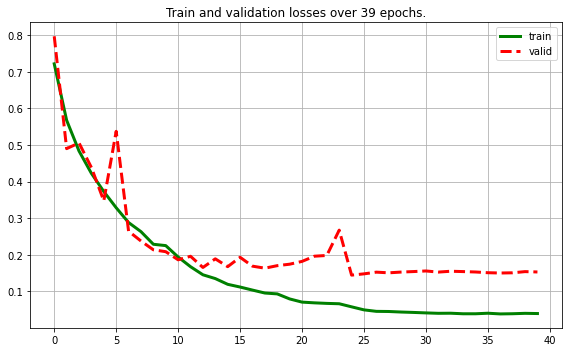

In [14]:
plt.figure(figsize=(8, 5))
plt.title(f"Train and validation losses over {epoch} epochs.")
plt.plot(train_losses, lw=3, c='g', label="train")
plt.plot(valid_losses, lw=3, ls="--", c='r', label="valid")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    maximize: False
    weight_decay: 0.01
)